In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

class KlineDataFetcher:
    @staticmethod
    def fetch_data(base, quote, interval, start_date, end_date):
        symbol = f"{base.upper()}{quote.upper()}"
        url = "https://api.binance.com/api/v3/klines"
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": int(datetime.fromisoformat(start_date).timestamp() * 1000),
            "endTime": int(datetime.fromisoformat(end_date).timestamp() * 1000),
            "limit": 1000
        }

        response = requests.get(url, params=params)
        data = response.json()

        df = pd.DataFrame(data, columns=[
            "timestamp", "open", "high", "low", "close", "volume", "close_time",
            "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume", "ignore"
        ])

        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        df["close"] = df["close"].astype(float)

        return df

class KlinePlotter:
    @staticmethod
    def plot(df, title="Historical Price", xlabel="Date", ylabel="Price (USDT)", save_path=None):
        if df.empty:
            raise ValueError("No data available to plot.")

        plt.figure(figsize=(14, 7))
        plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()


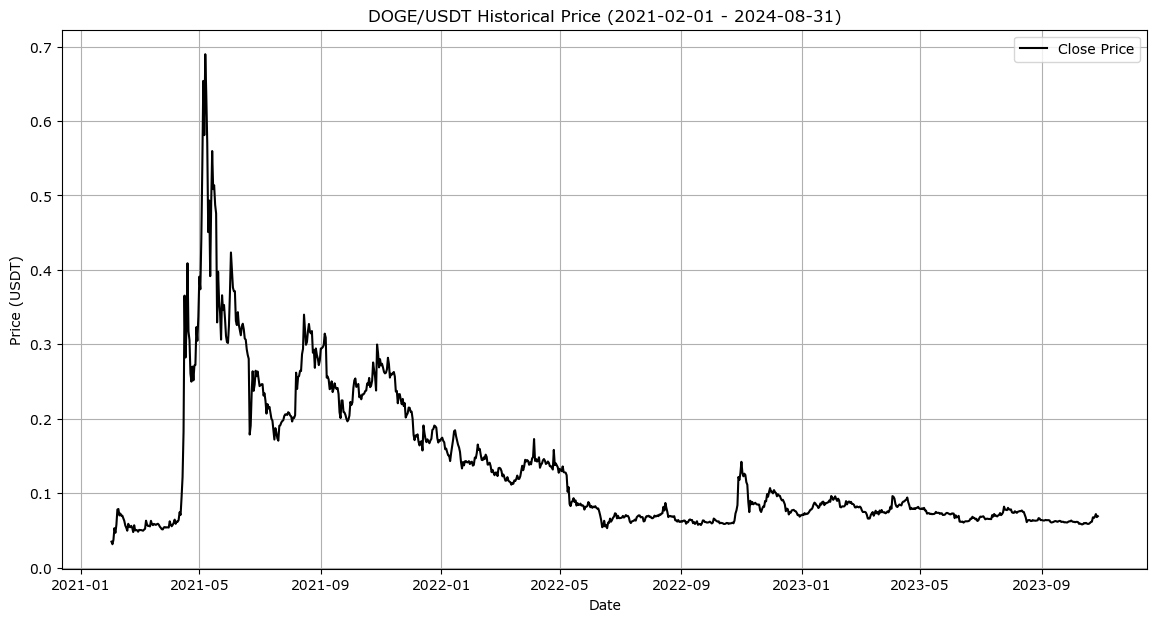

In [3]:
if __name__ == "__main__":
    base = "DOGE"
    quote = "USDT"
    interval = "1d"
    start_date = "2021-02-01"
    end_date = "2024-08-31"
    
    # Fetch data
    df = KlineDataFetcher.fetch_data(base, quote, interval, start_date, end_date)
    
    # Plot data
    KlinePlotter.plot(df, title=f"{base}/{quote} Historical Price ({start_date} - {end_date})")

In [18]:
import matplotlib.pyplot as plt

def highlight_sideways_market(df, ax=None, threshold=0.005, min_period=5, line_color='blue'):
    """
    Draws colored lines over the Klines plot to represent horizontal side swing periods.
    
    Parameters:
    - df: pandas DataFrame containing at least 'timestamp', 'high', 'low', and 'close' columns.
    - ax: Matplotlib axis object. If None, the function will create a new figure and axis.
    - threshold: The percentage range within which the price is considered to be moving sideways. Default is 0.5%.
    - min_period: The minimum number of consecutive periods (days) to consider as a sideways market. Default is 5 periods.
    - line_color: The color of the lines to draw for the sideways market. Default is 'blue'.
    
    Returns:
    - ax: The Matplotlib axis object with the plot and highlighted sideways market.
    """
    # Ensure that 'high', 'low', and 'close' columns are numeric
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    
    # Calculate the range percentage
    df['range_pct'] = (df['high'] - df['low']) / df['close']
    
    # Identify sideways market periods with a stricter threshold
    df['is_sideways'] = df['range_pct'] < threshold

    # Group consecutive sideways periods
    df['sideways_group'] = (df['is_sideways'] != df['is_sideways'].shift(1)).cumsum() * df['is_sideways']

    # Filter out short sideways periods
    sideways_periods = df.groupby('sideways_group').filter(lambda x: len(x) >= min_period)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.plot(df['timestamp'], df['close'], label='Close Price', color='black')

    # Draw lines for each sideways period with the specified color
    for _, period in sideways_periods.groupby('sideways_group'):
        start = period['timestamp'].iloc[0]
        end = period['timestamp'].iloc[-1]
        
        # Check if start and end are different
        if start != end:
            ax.axvline(x=start, color=line_color, linestyle='--', linewidth=1)
            ax.axvline(x=end, color=line_color, linestyle='--', linewidth=1)
            ax.hlines(y=period['close'].mean(), xmin=start, xmax=end, colors=line_color, linestyle='-', linewidth=2)

            # Break long periods into smaller segments by adjusting the threshold dynamically if needed
            sub_period = period[period['range_pct'] >= threshold / 2]
            if not sub_period.empty:
                sub_start = sub_period['timestamp'].iloc[0]
                sub_end = sub_period['timestamp'].iloc[-1]
                if sub_start != sub_end and sub_start != start and sub_end != end:
                    ax.axvline(x=sub_start, color=line_color, linestyle='--', linewidth=1)
                    ax.axvline(x=sub_end, color=line_color, linestyle='--', linewidth=1)
    
    return ax

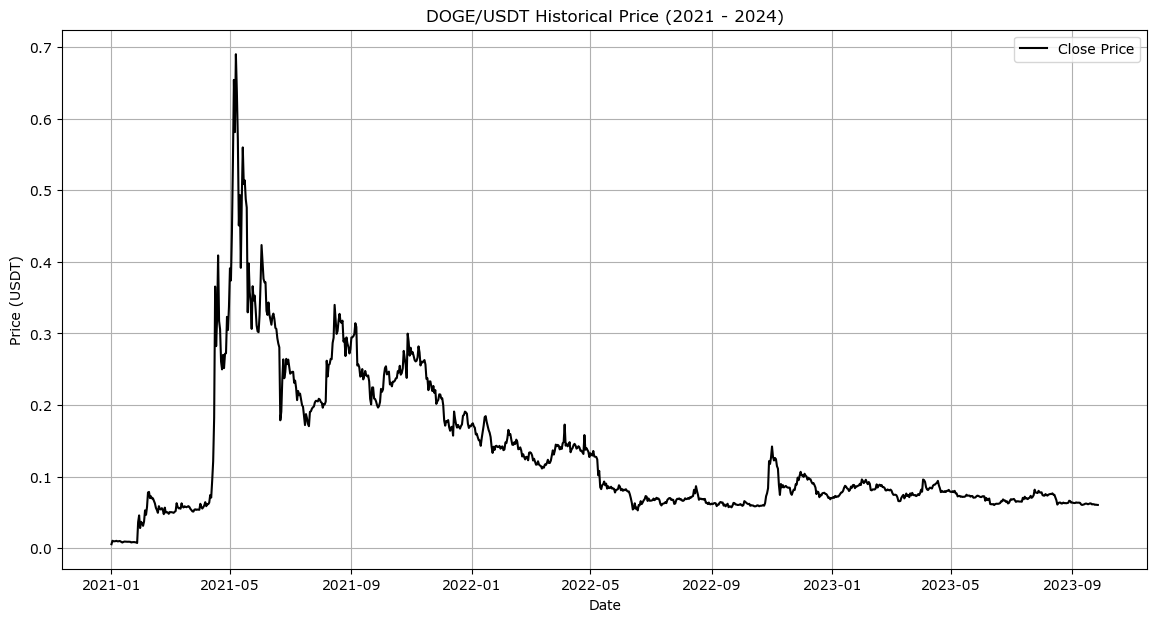

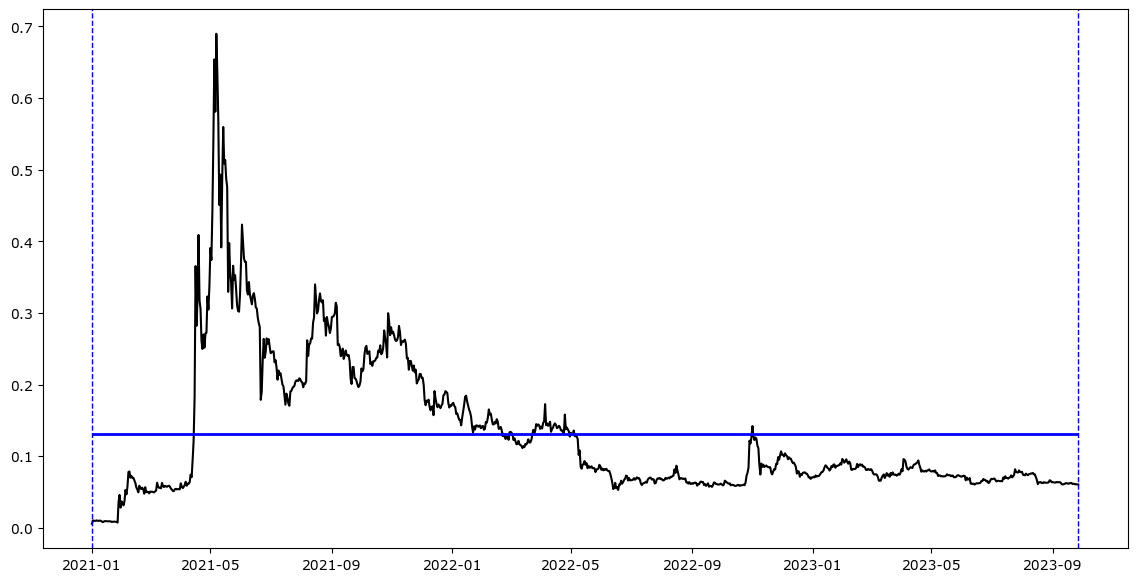

In [19]:
# Fetch data for DOGE/USDT
df = KlineDataFetcher.fetch_data(base="DOGE", quote="USDT", interval="1d", start_date="2021-01-01", end_date="2024-08-31")

# Plot the Kline data
ax = KlinePlotter.plot(df, title="DOGE/USDT Historical Price (2021 - 2024)")

# Highlight sideways market with a blue line
highlight_sideways_market(df, ax=ax, threshold=0.005, min_period=10, line_color='blue')

# Display the plot
plt.show()

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df['MA'] = df['close'].rolling(window).mean()
    df['STD'] = df['close'].rolling(window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * num_std_dev)
    df['Lower_Band'] = df['MA'] - (df['STD'] * num_std_dev)

def calculate_adx(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['+DM'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), np.maximum(df['high'] - df['high'].shift(1), 0), 0)
    df['-DM'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), np.maximum(df['low'].shift(1) - df['low'], 0), 0)

    df['+DI'] = 100 * (df['+DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['-DI'] = 100 * (df['-DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['DX'] = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window).mean()

def calculate_atr(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['ATR'] = df['TR'].rolling(window).mean()

def plot_with_bollinger_adx_atr(df, window=20, num_std_dev=2, adx_window=14, atr_window=14):
    # Calculate Bollinger Bands, ADX, and ATR
    calculate_bollinger_bands(df, window, num_std_dev)
    calculate_adx(df, adx_window)
    calculate_atr(df, atr_window)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Plot Closing Price with Bollinger Bands
    ax1.plot(df['timestamp'], df['close'], label='Close Price', color='black')
    ax1.plot(df['timestamp'], df['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='blue')
    ax1.plot(df['timestamp'], df['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='blue')

    # Highlight sideways markets where the bands are close together
    is_sideways = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < 0.05  # Adjust threshold as needed
    ax1.fill_between(df['timestamp'], df['Lower_Band'], df['Upper_Band'], where=is_sideways, color='blue', alpha=0.2)

    ax1.set_title(f"Price with Bollinger Bands ({window}-day window, {num_std_dev} std dev)")
    ax1.set_ylabel("Price (USDT)")
    ax1.legend()
    ax1.grid(True)

    # Plot ADX
    ax2.plot(df['timestamp'], df['ADX'], label='ADX', color='green')
    ax2.axhline(y=25, color='red', linestyle='--', label='Weak Trend Threshold')
    ax2.set_title(f"ADX (Average Directional Index, {adx_window}-day window)")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid(True)

    # Plot ATR
    ax3.plot(df['timestamp'], df['ATR'], label='ATR', color='purple')
    ax3.set_title(f"ATR (Average True Range, {atr_window}-day window)")
    ax3.set_ylabel("ATR Value")
    ax3.set_xlabel("Date")
    ax3.legend()
    ax3.grid(True)

    plt.show()

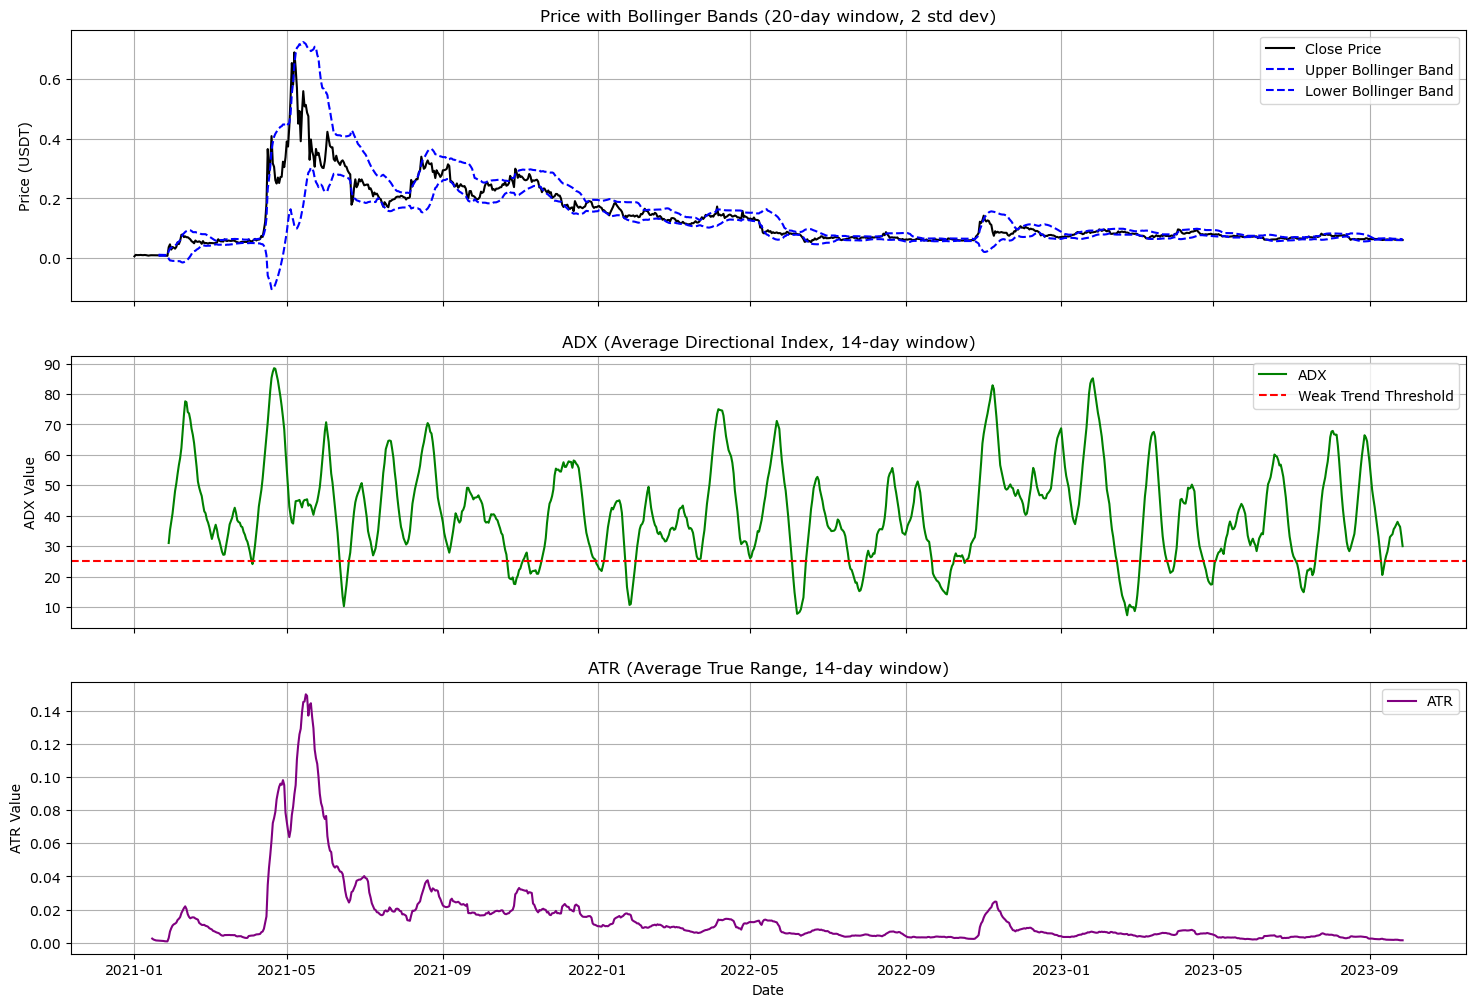

In [23]:
# Assuming you have a DataFrame 'df' with 'timestamp', 'high', 'low', and 'close' columns loaded from your data gathering process

# Plot the closing prices with Bollinger Bands, ADX, and ATR
plot_with_bollinger_adx_atr(df, window=20, num_std_dev=2, adx_window=14, atr_window=14)

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df['MA'] = df['close'].rolling(window).mean()
    df['STD'] = df['close'].rolling(window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * num_std_dev)
    df['Lower_Band'] = df['MA'] - (df['STD'] * num_std_dev)

def calculate_adx(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['+DM'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), np.maximum(df['high'] - df['high'].shift(1), 0), 0)
    df['-DM'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), np.maximum(df['low'].shift(1) - df['low'], 0), 0)

    df['+DI'] = 100 * (df['+DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['-DI'] = 100 * (df['-DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['DX'] = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window).mean()

def calculate_atr(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['ATR'] = df['TR'].rolling(window).mean()

def detect_sideways_market(df, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05):
    """
    Detects sideways market periods based on Bollinger Bands, ADX, and ATR.
    
    Parameters:
    - df: pandas DataFrame containing 'timestamp', 'high', 'low', 'close', 'ADX', and 'ATR'.
    - adx_threshold: ADX value below which the market is considered to have a weak trend. Default is 25.
    - atr_threshold: ATR value below which the market is considered to have low volatility. Default is 0.02.
    - bollinger_threshold: Percentage width of Bollinger Bands below which the market is considered to be moving sideways. Default is 0.05.
    
    Returns:
    - pandas DataFrame with an additional 'Sideways_Market' column indicating detected sideways periods.
    """
    # Calculate if Bollinger Bands are narrow
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold

    # Identify sideways market periods
    df['Sideways_Market'] = (df['ADX'] < adx_threshold) & (df['ATR'] < atr_threshold) & df['Bollinger_Narrow']
    
    return df

def plot_with_sideways_market_detection(df, window=20, num_std_dev=2, adx_window=14, atr_window=14, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05):
    # Calculate Bollinger Bands, ADX, and ATR
    calculate_bollinger_bands(df, window, num_std_dev)
    calculate_adx(df, adx_window)
    calculate_atr(df, atr_window)
    
    # Detect sideways market periods
    df = detect_sideways_market(df, adx_threshold, atr_threshold, bollinger_threshold)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Plot Closing Price with Bollinger Bands and highlight sideways market periods
    ax1.plot(df['timestamp'], df['close'], label='Close Price', color='black')
    ax1.plot(df['timestamp'], df['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='blue')
    ax1.plot(df['timestamp'], df['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='blue')
    ax1.fill_between(df['timestamp'], df['Lower_Band'], df['Upper_Band'], where=df['Sideways_Market'], color='yellow', alpha=0.3)

    ax1.set_title(f"Price with Bollinger Bands and Sideways Market Detection ({window}-day window, {num_std_dev} std dev)")
    ax1.set_ylabel("Price (USDT)")
    ax1.legend()
    ax1.grid(True)

    # Plot ADX
    ax2.plot(df['timestamp'], df['ADX'], label='ADX', color='green')
    ax2.axhline(y=adx_threshold, color='red', linestyle='--', label='Weak Trend Threshold')
    ax2.set_title(f"ADX (Average Directional Index, {adx_window}-day window)")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid(True)

    # Plot ATR
    ax3.plot(df['timestamp'], df['ATR'], label='ATR', color='purple')
    ax3.axhline(y=atr_threshold, color='orange', linestyle='--', label='Low Volatility Threshold')
    ax3.set_title(f"ATR (Average True Range, {atr_window}-day window)")
    ax3.set_ylabel("ATR Value")
    ax3.set_xlabel("Date")
    ax3.legend()
    ax3.grid(True)

    plt.show()

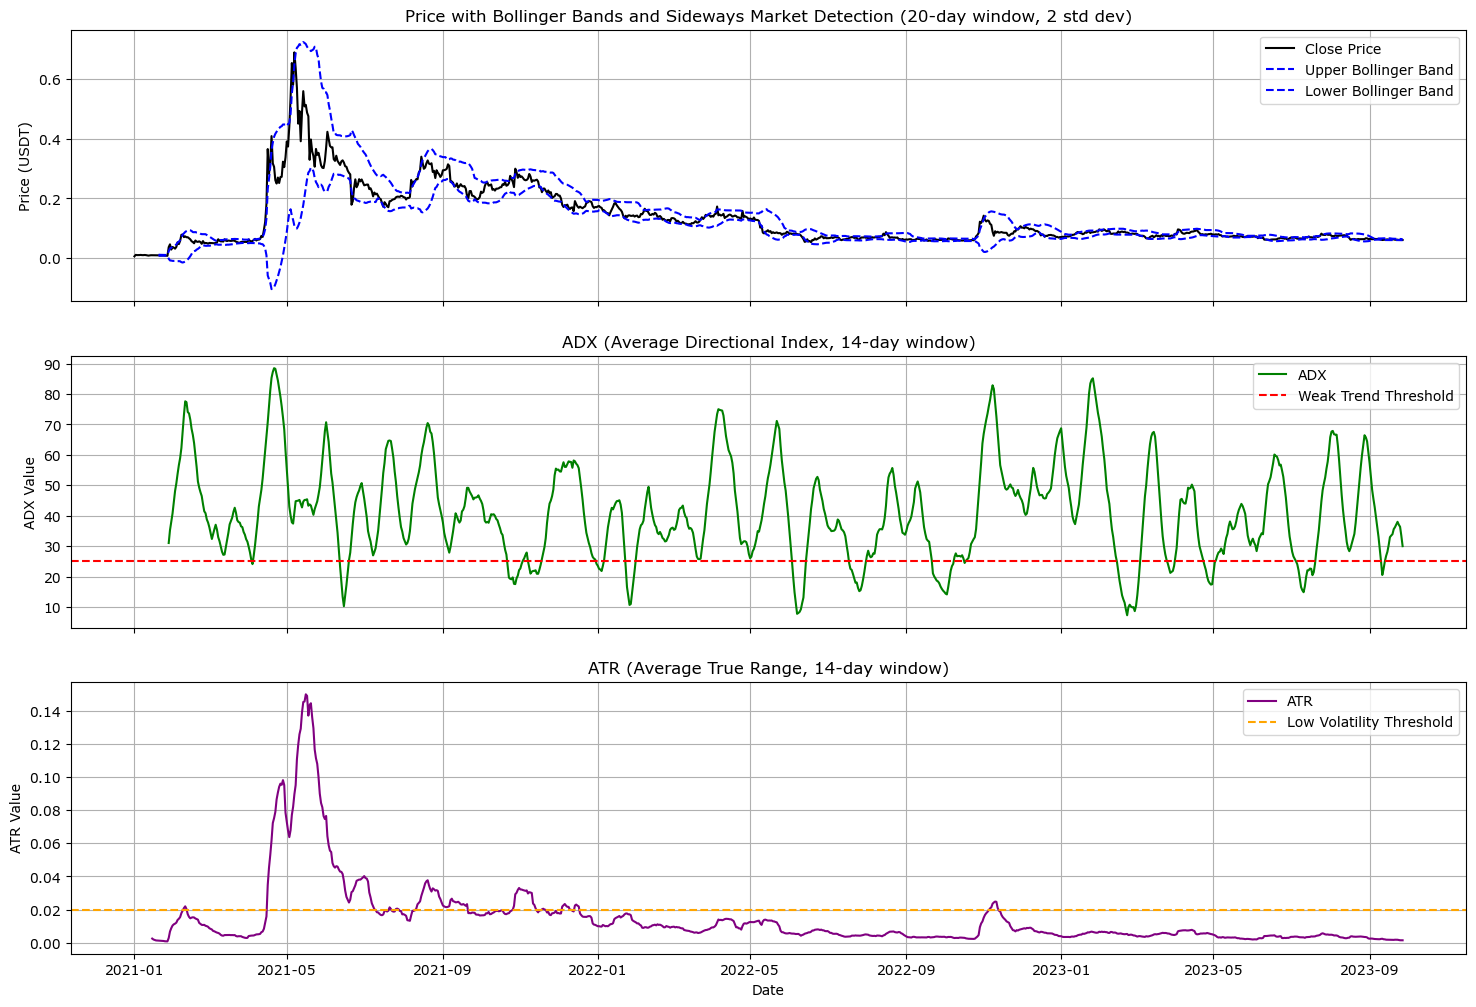

In [25]:
# Assuming you have a DataFrame 'df' with 'timestamp', 'high', 'low', 'close' columns loaded from your data gathering process

# Plot the closing prices with Bollinger Bands, ADX, ATR, and highlight detected sideways markets
plot_with_sideways_market_detection(df, window=20, num_std_dev=2, adx_window=14, atr_window=14, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05)